#Import


 

Let's import tensorflow as tf.
>
We then import a library called numpy, which helps us to represent our data as lists easily and quickly.
>
The framework for defining a neural network as a set of Sequential layers is called keras, so we import that too.
>
Then we import the functions like activation,dense, Con2d that wiil be needed to build over our model.



In [ ]:

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape,Concatenate
from keras import backend as K
from keras.optimizers import Adam
from keras.models import load_model
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator

from warnings import filterwarnings
filterwarnings('ignore')


##Extracting Zip file
>
The zip file is needed to be uploaded to the content folder from this link.
>
https://drive.google.com/file/d/1mGk7EBFCERTPaxUQ_U03MIst2KYtCNOF/view?usp=sharing
>
After uploading the zip file can be extracted by this command block.If the file is unzipped succesfully the code will print done .

# New Section

In [ ]:
from zipfile import ZipFile
file_name='skin-lesion-segmentation.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


##Sorting The Images
>>
Now a function in defined to sort the images numericially to do that we take the numerical part of the image title .

In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

##Loading Data
>
The image data were loaded in a numerical order.

In [ ]:
filelist_trainx = sorted(glob.glob('../content/trainx/*.jpg'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('../content/trainy/*.jpg'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])

filelist_testx = sorted(glob.glob('../content/testx/*.jpg'), key=numericalSort)
X_test = np.array([np.array(Image.open(fname)) for fname in filelist_testx])

filelist_testy = sorted(glob.glob('../content/testy/*.jpg'), key=numericalSort)
Y_test = np.array([np.array(Image.open(fname)) for fname in filelist_testy])

filelist_valx = sorted(glob.glob('../content/validationx/*.jpg'), key=numericalSort)
X_val = np.array([np.array(Image.open(fname)) for fname in filelist_valx])

filelist_valy = sorted(glob.glob('../content/validationy/*.jpg'), key=numericalSort)
Y_val = np.array([np.array(Image.open(fname)) for fname in filelist_valy])

Here we show the image and its' grown truth.

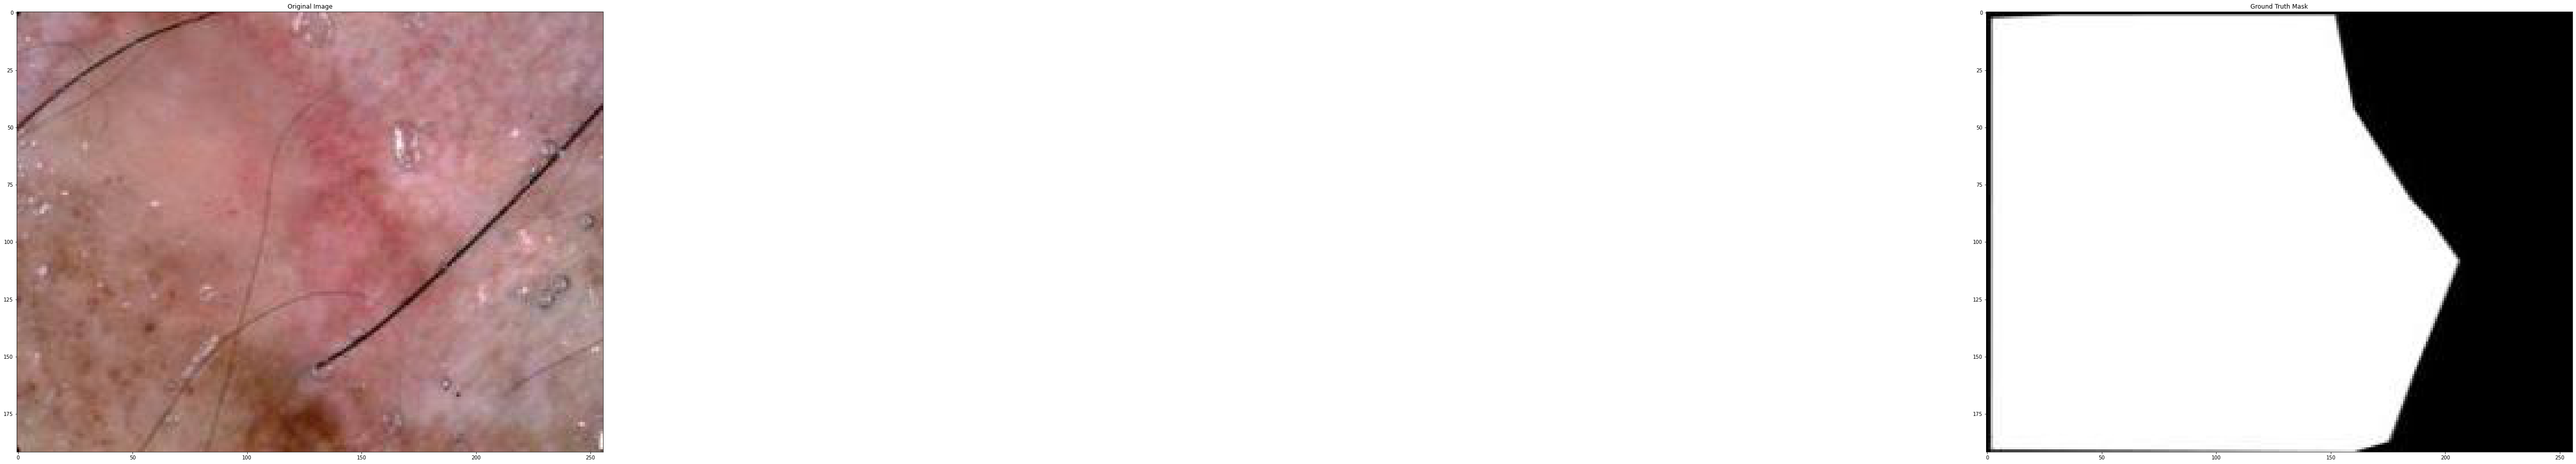

In [ ]:
img_num = 190
plt.figure(figsize=(128,16))
plt.subplot(1,2,1)
plt.imshow(X_test[img_num])
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth Mask')
plt.show()

In [ ]:
(x_train, y_train), (x_test, y_test), (x_val, y_val) = (X_train, Y_train), (X_test, Y_test), (X_val, Y_val)

##Model
>
This is a U-net model which consists of 3 Downsampling layers 2 Dense layers and 3 Upsampling layers .The dense layers in between the upsampling layers and downsampling layers. 

In [ ]:
def model_seg(epochs_num,save_name):
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    xa= MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv3')(xa)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (4, 4), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    xb = MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv5')(xb)
    x = BatchNormalization(name='bn5')(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Dropout(0.5)(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)


    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Deconvolution Layers (BatchNorm after non-linear activation)

    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    #x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    us1 = UpSampling2D()(x)
    concat = Concatenate()([us1, xb])
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(concat)
    #x = Conv2D(256, (3, 3), padding='same', name='conv9')(concat)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    #x = Conv2D(128, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    us2 = UpSampling2D(size=(2, 2))(x)
    concat = Concatenate()([us2, xa])
    
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(concat)
    #x = Conv2D(1, (3, 3), padding='same', name='conv11')(concat)
    x = BatchNormalization(name='bn11')(x)
    x = UpSampling2D(size=(2, 2))(x)
  
    
    
    x = Activation('relu')(x)
    pred = Reshape((192,256))(x)

    model = Model(inputs=img_input, outputs=pred)
    model.summary()
    model.compile(optimizer= Adam(lr = 0.003), loss= [categorical_crossentropy], metrics=[accuracy])
    
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18,validation_data=(X_val, y_val), verbose=1)
    model.save(save_name)

    accuracy = model.evaluate(x=x_test,y=y_test,batch_size=18)
    print("Accuracy: ",accuracy[1])
    
  
  

In [ ]:
model_seg(epochs_num= 5, save_name= "model_exact_epoch_1.h5")

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 192, 256, 16) 1216        input_11[0][0]                   
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 192, 256, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 192, 256, 16) 0           bn1[0][0]                        
______________________________________________________________________________________

###Compling a Model
>
Now we compile a model where we can load our  adjusted weights which we got after running the model for severely times.

In [ ]:
    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    xa= MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv3')(xa)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (4, 4), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    xb = MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv5')(xb)
    x = BatchNormalization(name='bn5')(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Dropout(0.5)(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Deconvolution Layers (BatchNorm after non-linear activation)

    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    #x = Conv2D(256, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    us1 = UpSampling2D()(x)
    concat = Concatenate()([us1, xb])
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(concat)
    #x = Conv2D(256, (3, 3), padding='same', name='conv9')(concat)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    #x = Conv2D(128, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    us2 = UpSampling2D(size=(2, 2))(x)
    concat = Concatenate()([us2, xa])
    
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(concat)
    #x = Conv2D(1, (3, 3), padding='same', name='conv11')(concat)
    x = BatchNormalization(name='bn11')(x)
    x = UpSampling2D(size=(2, 2))(x)
    
    x = Dropout(0.5)(x) # not original

    x = Activation('relu')(x)
    pred = Reshape((192,256))(x)


In [ ]:
model = Model(inputs=img_input, outputs=pred)
model.compile(optimizer= Adam(lr=0.003), loss= ['categorical_crossentropy'], metrics=['accuracy'])

In [ ]:
model.load_weights('model_exact_epoch_1.h5')

##Testing the Model
Now we test the model by showing the input ,growth truth and output we got from the model side by side.


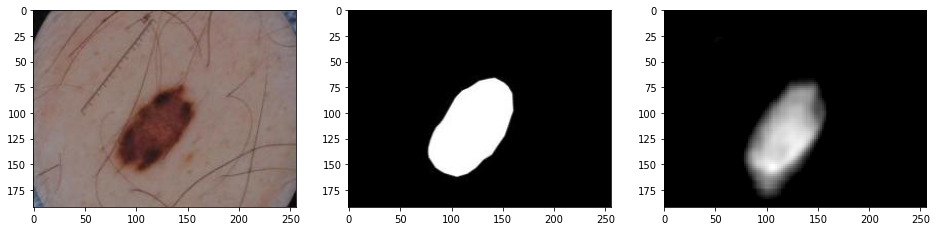

In [ ]:
img_num = 111
img_pred = model.predict(X_test[img_num].reshape(1,192,256,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(X_test[img_num])
plt.subplot(1,3,2)
plt.imshow(Y_test[img_num], plt.cm.binary_r)
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(192, 256), plt.cm.binary_r)
plt.show()